# CASE PARA TAREFAS DE HEAVY USERS
____


Basicamente o que faremos aqui será uma análise sobre como realizar tarefas de Heavy Users!! No entanto, o que é Heavy Users?   
> Heavy Users tasks são tarefas de análise e indentificação de usuários que possam ser considerados bons ou ruins. Em suma é uma tarefa de classificação de clientes com base em seu comportamento!   
   
Com base nisso, vamos analisar um dataset que pode ser encontrado neste link: [link](https://archive.ics.uci.edu/ml/datasets/online+retail)! Esse dataset é um conjunto de dados transacionais de uma loja de varejo do Reino Unido entre 2010 e 2011. Através desse dataset vamos identificar o comportamento dos clientes e classificá-los através de uma tabela de RFV (Recência, Frequência e Valor Monetário) que simboliza a quanto tempo foi a ultima compra, a frequência de compra e por fim o valor médio de cada compra.

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

#Importando dados
df = pd.read_excel('Online Retail.xlsx')

In [2]:
#Analisando os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
#Analisando os dados
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Attribute Information:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

Basicamente temos uma grande quantidade de informações não nulas na maioria dos dados!   
Além disso, há poucas colunas o que simplifica os tipos de trabalhos que podem ser feitos. No geral, queremos analisar como cada cliente se comporta e se há alguma forma de classificar os clientes.

In [4]:
#Retirando os valores nulos com base na coluna de costumer ID
df = df.loc[df.CustomerID.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [5]:
#Veja que agora todas as colunas não sofrem de dados faltantes, vamos então analisar quantidade de clientes únicos
df.CustomerID.unique().shape

(4372,)

In [6]:
#Das 406829 linhas há apenas 4372 clientes, o que facilita nossa análise final!
#Vamos limpar transações canceladas
df = df.loc[~(df.InvoiceNo.str.contains('^C', na=False))]

In [7]:
#Agora vamos criar uma coluna de total comprado
df.loc[:, 'Total'] = df.loc[:, 'UnitPrice'] * df.loc[:, 'Quantity']

In [8]:
#Criando um valor agregado considerando a data máxima como a data mais recente mais 1 dia
max_date = df.InvoiceDate.max() + pd.Timedelta(days = 1)

In [9]:
#Criando coluna agregada
RFV = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (max_date - x.max()).days,
                                    'InvoiceNo': 'count',
                                    'Total': 'sum'})

#Analisando
RFV.rename(columns = {'InvoiceDate': 'Recencia', 'InvoiceNo': 'Frequencia', 'Total': 'Valor_Total'}, inplace = True)

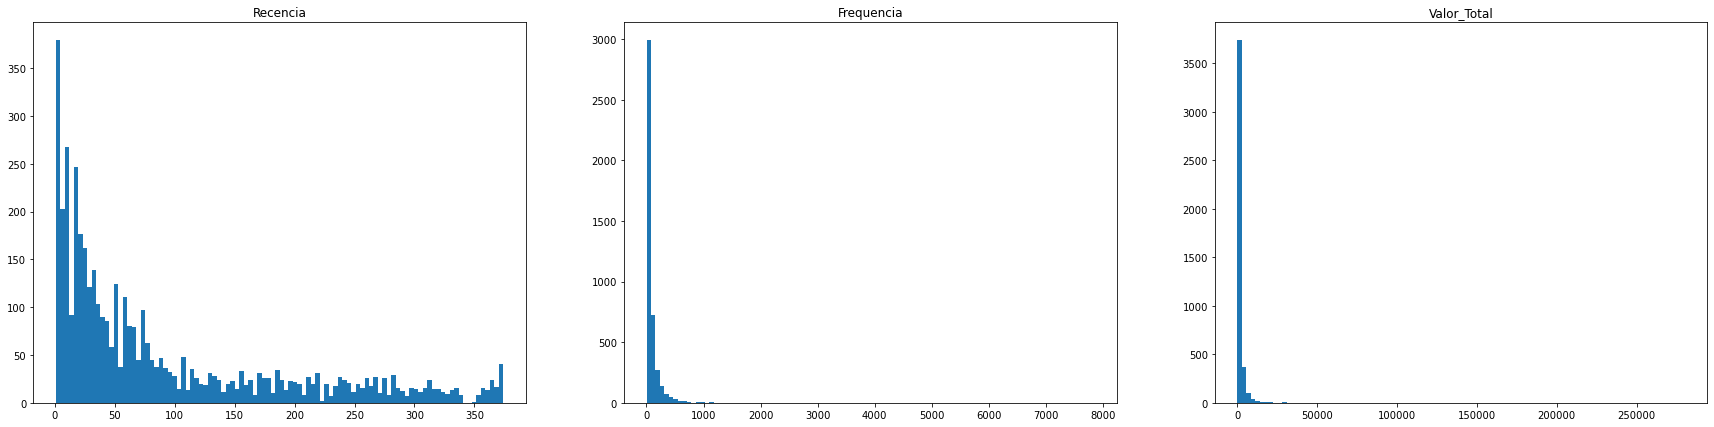

In [10]:
#Agora temos a RFV e podemos analisar nossos dados
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 7))
for i, ax in zip(range(0, 3), axes):
    ax.hist(RFV.iloc[:, i], bins = 100)
    ax.set_title(RFV.iloc[:, i].name)

>> #### Precisamos que os dados se encaixem na seguinte afirmação: Não tenham assimetria e tenham a mesma Média e Variância!   
   
Infelizmente, para que isso aconteça, apenas um milagre resolveria! Na pratica é impossível alcançarmos isso, no entanto, é possível aproximar ao máximo nossos dados disso!   
Visto isso, nossos passos serão:
1. Realizar transformação nos dados
2. Aplicar uma padronização!

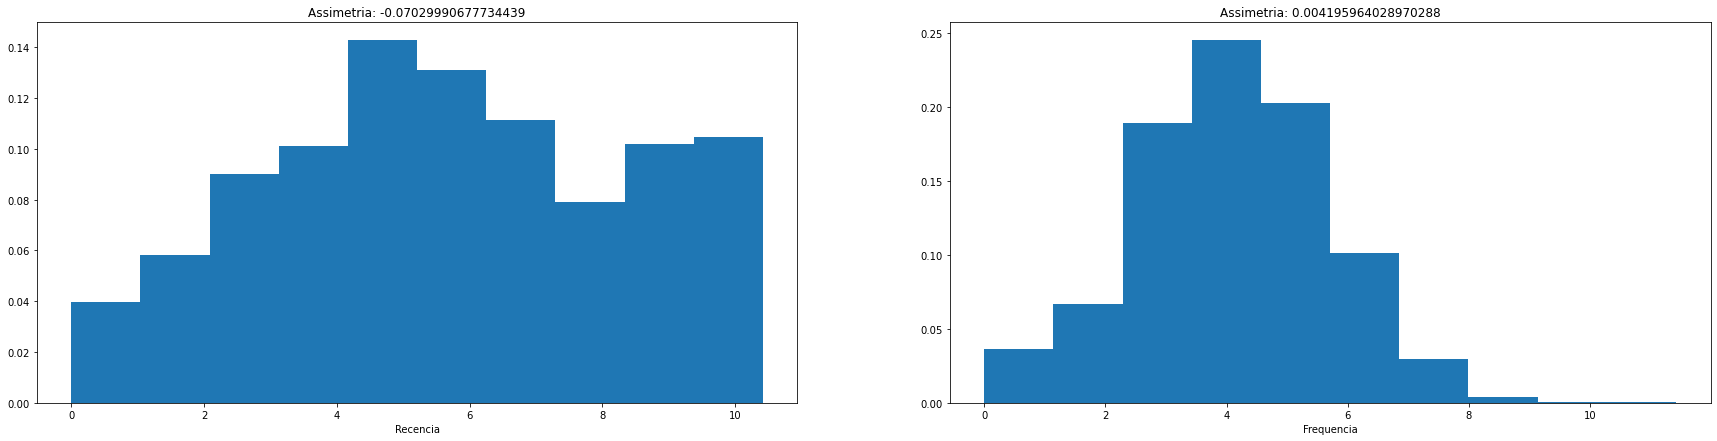

In [11]:
#Primeiro, vamos aplicar nossos dados com boxcox
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 7))
for i, ax in zip(range(0, 2), axes):
    ax.hist(sts.boxcox(RFV.iloc[:, i])[0], bins = 10, density = True)
    ax.set_xlabel(RFV.iloc[:, i].name)
    ax.set_title(f'Assimetria: {sts.skew(sts.boxcox(RFV.iloc[:, i])[0])}')

Text(0.5, 1.0, 'Assimetria: 2.995679413440887 \n            Antes: 19.32030329073974')

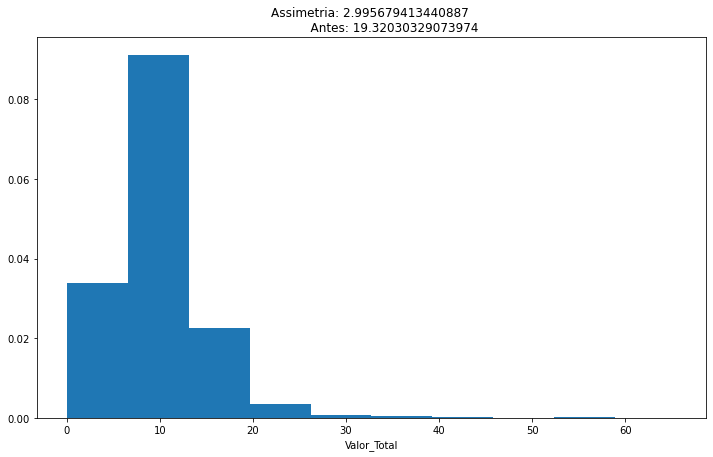

In [12]:
#Agora vamos fazer a assimetria da variável que tem valores negativos usando a raiz cúbica
#Primeiro, vamos aplicar nossos dados com boxcox
fig, ax = plt.subplots(figsize = (12, 7))
ax.hist(np.power(RFV.iloc[:, 2], 1/3), bins = 10, density = True)
ax.set_xlabel(RFV.iloc[:, 2].name)
ax.set_title(f"""Assimetria: {sts.skew(np.power(RFV.iloc[:, 2], 1/3))} 
            Antes: {sts.skew(RFV.iloc[:, 2])}""")

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


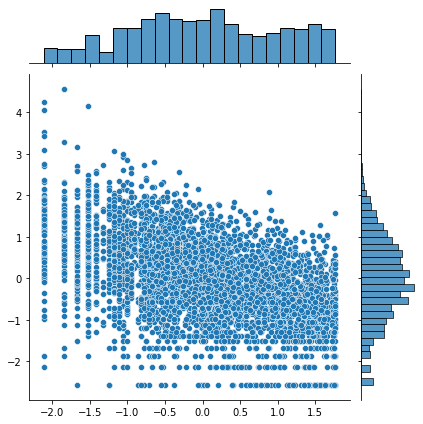

In [13]:
#Importando biblioteca para padronizar
recencia = sts.boxcox(RFV.iloc[:, 0])[0]
recencia = (recencia - recencia.mean())/recencia.std()

frequencia = sts.boxcox(RFV.iloc[:, 1])[0]
frequencia = (frequencia - frequencia.mean())/frequencia.std()

valor = np.power(RFV.iloc[:, 2], 1/3)
valor = (valor - valor.mean())/valor.std()


#Verificando se são esféricas
sns.jointplot(recencia, frequencia)

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


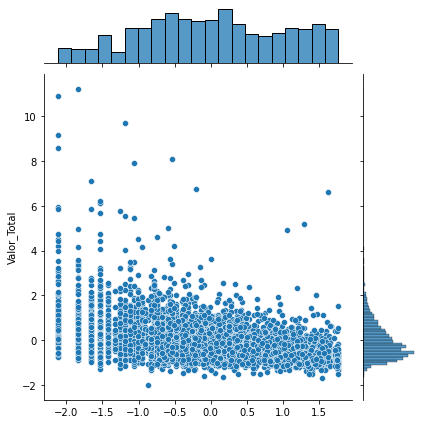

In [14]:
#Verificando se são esféricas
sns.jointplot(recencia, valor)

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


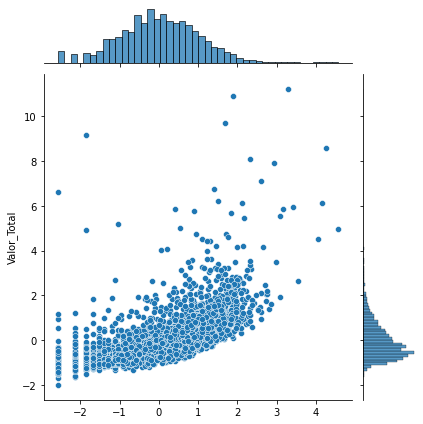

In [15]:
#Verificando se são esféricas
sns.jointplot(frequencia, valor)

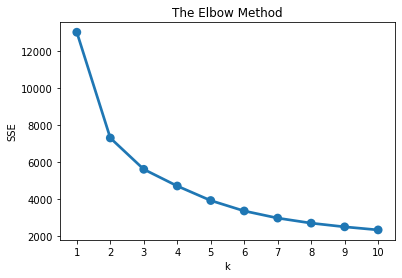

In [16]:
#Treinando um modelo de exemplo
from sklearn.cluster import KMeans
customers_normalized = pd.DataFrame({'Recencia': recencia, "Frequencia": frequencia,
                                    "Valor": valor})

#Testando o Método Elbow
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [17]:
#Observando o Elbow, podemos considerar que 3 clusters são o suficiente
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape


RFV["Cluster"] = model.labels_
RFV.groupby('Cluster').agg({
    'Recencia':'mean',
    'Frequencia':'mean',
    'Valor_Total':['mean', 'count']}).round(2)

Recencia Frequencia Valor_Total      
            mean       mean        mean count
Cluster                                      
0         184.23      19.66      388.95  1653
1          19.98     308.89     8178.52   766
2          42.50      67.09     1043.61  1920

>> ### Com esse resultado, basicamente temos 3 tipos de clientes!   
1. Clientes com recência alta, frequência baixa e baixo valor gasto são clientes com grandes chances de serem perdidos ou já foram perdidos.
2. Clientes com recência baixa, frequência alta e alto valor gasto são clientes leais.
3. Clientes com recência baixa, frequência baixa e valor gasto razoável são potências novos clientes leais!

___
# Agora que fizemos uma abordagem mais clusterizada com K-Means, vamos fazer uma abordagem supervisionada!
___
Para este dataset vamos utilizar os dados do conjunto da competição do SANTANDER! Link para encontrar o dataset: [link](https://www.kaggle.com/competitions/santander-product-recommendation/data?select=train_ver2.csv.zip)!


In [18]:
#Carregando os dados
import dask.dataframe as dd 

df_santander = pd.read_csv('train_ver2.csv', low_memory=False)
df_santander = dd.from_pandas(df_santander, npartitions = 16)

In [19]:
#Vamos explorar nossos dados através de amostras
df_sample = df_santander.sample(frac=0.1, random_state = 42).compute()
df_sample

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
319323,2015-01-28,266747,N,ES,V,43,2001-08-09,0.0,167,1.0,...,1,0,0,0,0,0,0,0.0,0.0,1
12244,2015-01-28,1068622,N,ES,H,27,2012-09-27,0.0,34,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
266061,2015-01-28,1155287,N,ES,H,25,2013-08-03,0.0,23,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
287036,2015-01-28,1252115,N,ES,V,39,2014-04-04,0.0,15,1.0,...,0,0,0,0,0,0,0,1.0,1.0,1
108406,2015-01-28,922821,N,ES,H,24,2011-07-27,0.0,48,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328625,2016-05-28,1540014,N,ES,H,31,2016-03-16,1.0,2,1.0,...,0,0,0,0,0,0,0,1.0,1.0,1
13100658,2016-05-28,461025,N,ES,V,42,2004-02-24,0.0,147,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
12971431,2016-05-28,155803,N,ES,V,65,2000-01-11,0.0,196,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
13568250,2016-05-28,1259839,N,ES,V,57,2014-05-26,0.0,24,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [20]:
#Analisando tamanho
substring = 'NA'
resultados = {}
for col in df_sample.columns:
    if df_sample[col].dtypes == 'object':
        resultados[col] = df_sample[df_sample[col].str.contains(' NA', na = False)].index

In [21]:
#Manipulando para pegar os indexs
indexes = np.array([np.array(resultados[key]) for key in resultados if len(resultados[key]) > 0]).reshape(1,-1)
np.unique(indexes)

array([   2487,    3414,    4150, ..., 3774795, 3775976, 3776230],
      dtype=int64)

In [22]:
(df_sample.isna().sum()/df_sample.shape[0])

fecha_dato               0.000000
ncodpers                 0.000000
ind_empleado             0.002006
pais_residencia          0.002006
sexo                     0.002014
age                      0.000000
fecha_alta               0.002006
ind_nuevo                0.002006
antiguedad               0.000000
indrel                   0.002006
ult_fec_cli_1t           0.998163
indrel_1mes              0.011051
tiprel_1mes              0.011051
indresi                  0.002006
indext                   0.002006
conyuemp                 0.999864
canal_entrada            0.013684
indfall                  0.002006
tipodom                  0.002006
cod_prov                 0.006894
nomprov                  0.006894
ind_actividad_cliente    0.002006
renta                    0.204639
segmento                 0.013901
ind_ahor_fin_ult1        0.000000
ind_aval_fin_ult1        0.000000
ind_cco_fin_ult1         0.000000
ind_cder_fin_ult1        0.000000
ind_cno_fin_ult1         0.000000
ind_ctju_fin_u

In [23]:
#Limpando nossa amostra
#df_sample = df_sample.drop(index=np.unique(indexes))
df_sample = df_sample.loc[:, ~((df_sample.isna().sum()/df_sample.shape[0]) > 0.21)] #limpando colunas que tenha mais do que 15% de dados nulos

In [24]:
#Limpando dados faltantes
print(df_sample.shape[0])
df_sample.dropna(inplace = True)
print(df_sample.shape[0])

1364735
1079745


c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
#Verificando se limpamos tudo
df_sample.loc[:, [col for col in df_sample.columns if df_sample[col].dtypes == 'object' and df_sample[col].str.contains('NA').shape[0] > 0]]

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,nomprov,segmento
319323,2015-01-28,N,ES,V,43,2001-08-09,167,1,A,S,N,KAT,N,SEVILLA,02 - PARTICULARES
12244,2015-01-28,N,ES,H,27,2012-09-27,34,1,I,S,N,KHE,N,HUELVA,03 - UNIVERSITARIO
266061,2015-01-28,N,ES,H,25,2013-08-03,23,1.0,I,S,N,KAT,N,"PALMAS, LAS",03 - UNIVERSITARIO
287036,2015-01-28,N,ES,V,39,2014-04-04,15,1.0,A,S,N,KAT,N,HUELVA,02 - PARTICULARES
108406,2015-01-28,N,ES,H,24,2011-07-27,48,1.0,I,S,N,KHE,N,CORDOBA,03 - UNIVERSITARIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13221343,2016-05-28,N,ES,H,21,2015-07-21,10,1.0,A,S,N,KHQ,N,BARCELONA,03 - UNIVERSITARIO
12941148,2016-05-28,N,ES,V,56,2008-12-30,24,1,A,S,N,KAT,N,MADRID,01 - TOP
13100658,2016-05-28,N,ES,V,42,2004-02-24,147,1.0,A,S,N,KFC,N,CADIZ,02 - PARTICULARES
12971431,2016-05-28,N,ES,V,65,2000-01-11,196,1.0,I,S,N,KFC,N,MADRID,02 - PARTICULARES


In [26]:
#Foi verificado essas supostas colunas e nada encontrado!
df_sample.loc[:, ['fecha_dato', 'fecha_alta']] = df_sample.loc[:, ['fecha_dato', 'fecha_alta']].astype('datetime64')
df_sample['antiguedad'] = df_sample['antiguedad'].astype(int)
df_sample['age'] = df_sample['age'].astype(int)

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is tr

In [27]:
#Certificando nossos dados
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079745 entries, 319323 to 13568250
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   fecha_dato             1079745 non-null  datetime64[ns]
 1   ncodpers               1079745 non-null  int64         
 2   ind_empleado           1079745 non-null  object        
 3   pais_residencia        1079745 non-null  object        
 4   sexo                   1079745 non-null  object        
 5   age                    1079745 non-null  int32         
 6   fecha_alta             1079745 non-null  datetime64[ns]
 7   ind_nuevo              1079745 non-null  float64       
 8   antiguedad             1079745 non-null  int32         
 9   indrel                 1079745 non-null  float64       
 10  indrel_1mes            1079745 non-null  object        
 11  tiprel_1mes            1079745 non-null  object        
 12  indresi               

In [28]:
#Vamos criar uma coluna com quantidade de produtos que um cliente consome
df_sample.loc[:, 'Contagem_Prod'] = 0
df_sample.loc[:, 'Contagem_Prod'] =  df_sample.iloc[:, 21:45].isin([1]).sum(axis = 1)

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<BarContainer object of 3 artists>

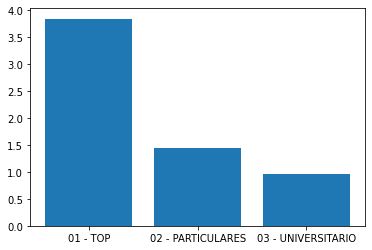

In [29]:
#Analisando como funciona, em média, como cada segmento se comporta
agg = df_sample.groupby(['segmento', 'ncodpers'])['Contagem_Prod'].max().reset_index()
agg = agg.groupby('segmento')['Contagem_Prod'].mean()
plt.bar(x = agg.index, height= agg)

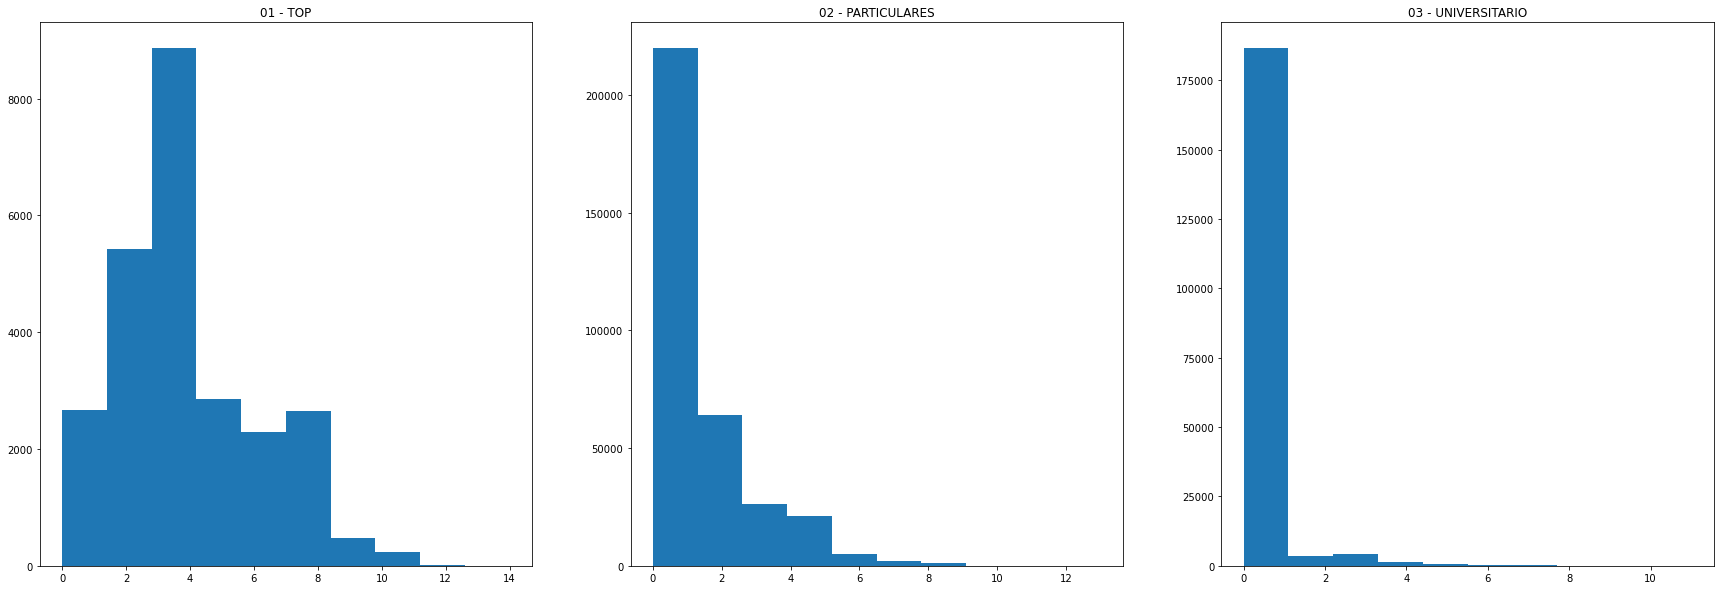

In [30]:
#Analisando distribuição de cada segmento
agg = df_sample.groupby(['segmento', 'ncodpers']).agg({'Contagem_Prod': 'max', 'renta': 'max'}).reset_index()
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (30, 10))
for seg, i in zip(agg.segmento.unique(), range(0, 3)):
    axes[i].hist(agg.loc[agg.segmento == seg, 'Contagem_Prod'])
    axes[i].set_title(seg)

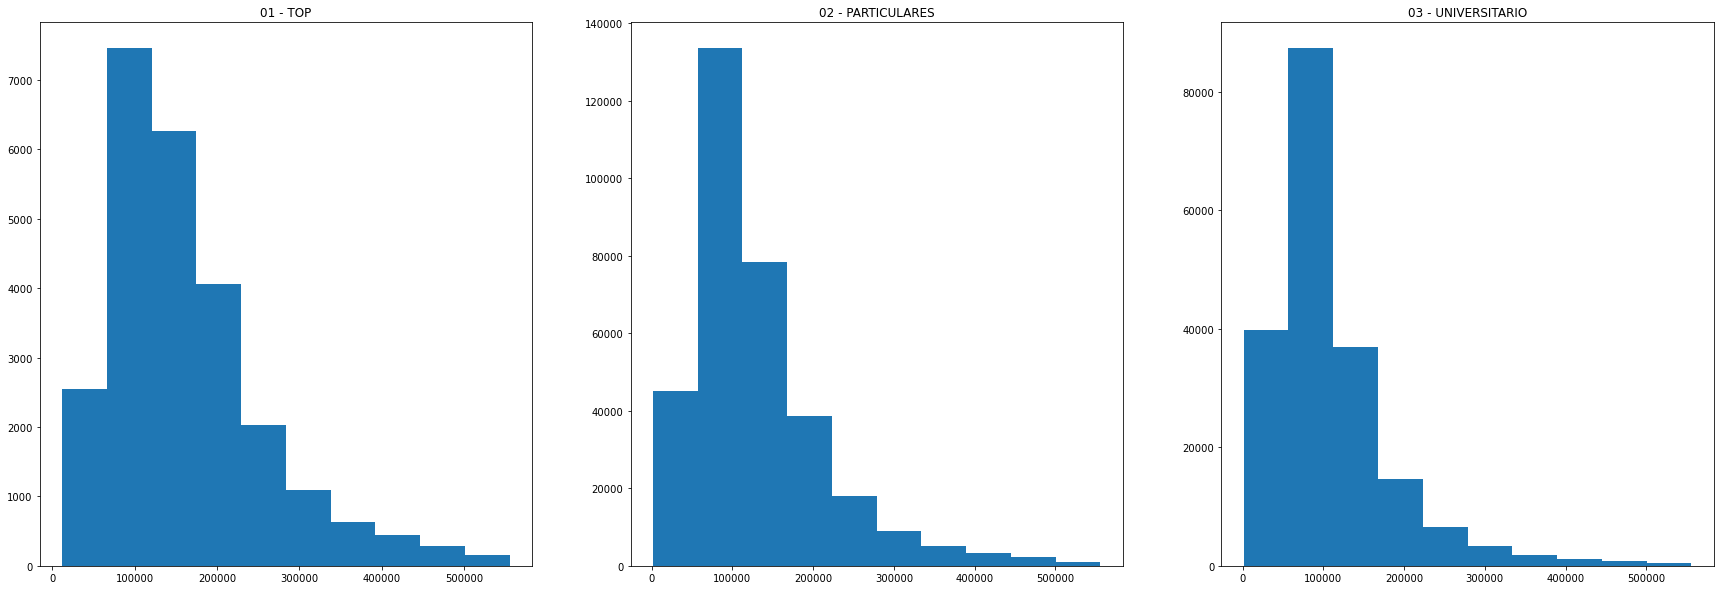

In [31]:
#Analisando distribuição de cada segmento
agg = df_sample.groupby(['segmento', 'ncodpers']).agg({'Contagem_Prod': lambda x: (x.max() - x.min()), 'renta': 'max',
                                                        'antiguedad': 'max'}).reset_index()
agg = agg.loc[agg.renta <= agg.renta.quantile(0.99)]
agg = agg.loc[agg.antiguedad >= agg.antiguedad.quantile(0.01)]
fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (30, 10))
for seg, i in zip(agg.segmento.unique(), range(0, 3)):

    axes[i].hist(agg.loc[agg.segmento == seg, 'renta'])
    axes[i].set_title(seg)

In [32]:
#Analisando
agg

,segmento,ncodpers,Contagem_Prod,renta,antiguedad
0,01 - TOP,15889,0,326124.90,254
1,01 - TOP,15890,0,71461.20,254
2,01 - TOP,15892,0,430477.41,253
3,01 - TOP,15897,0,175450.05,256
4,01 - TOP,15899,0,130835.64,250
...,...,...,...,...,...
562229,03 - UNIVERSITARIO,1454614,0,109237.35,7
562230,03 - UNIVERSITARIO,1454616,0,132889.62,5
562231,03 - UNIVERSITARIO,1454617,0,58476.27,3
562232,03 - UNIVERSITARIO,1454618,0,75904.50,7


c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


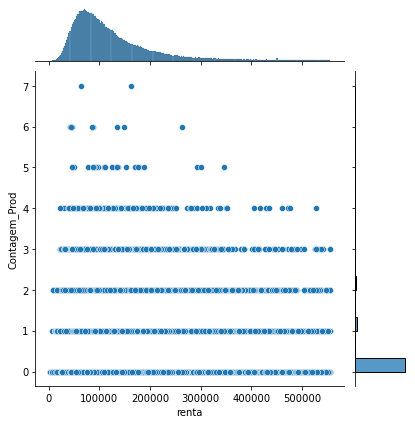

In [33]:
#Avaliando a combinação da renda com a quantidade de produtos adiquiridos nesse tempo
sns.jointplot(agg.renta, agg.Contagem_Prod)

In [34]:
#Avaliando a senioridade em meses
agg.antiguedad.describe(percentiles=[0.01, 0.25, 0.50, 0.75])

count    552552.000000
mean         84.785329
std          66.182048
min           3.000000
1%            5.000000
25%          28.000000
50%          55.000000
75%         141.000000
max         256.000000
Name: antiguedad, dtype: float64

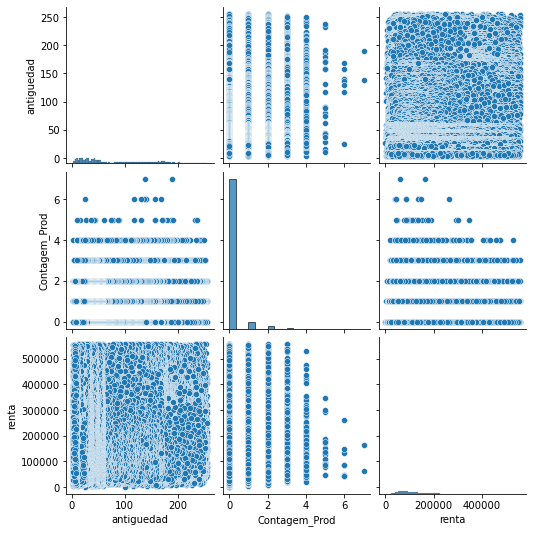

In [35]:
#E se tentarmos trazer a informação da renda e senioridade como clusters?
sns.pairplot(agg[['antiguedad', 'Contagem_Prod', 'renta']])

___
O que faremos agora será trazer as informações contidas na senioridade e na renda de uma forma que simplifique a informação.   
Para isso, faremos a mesma abordagem da clusterização!
___

Text(0.5, 1.0, '-0.10180249744635941')

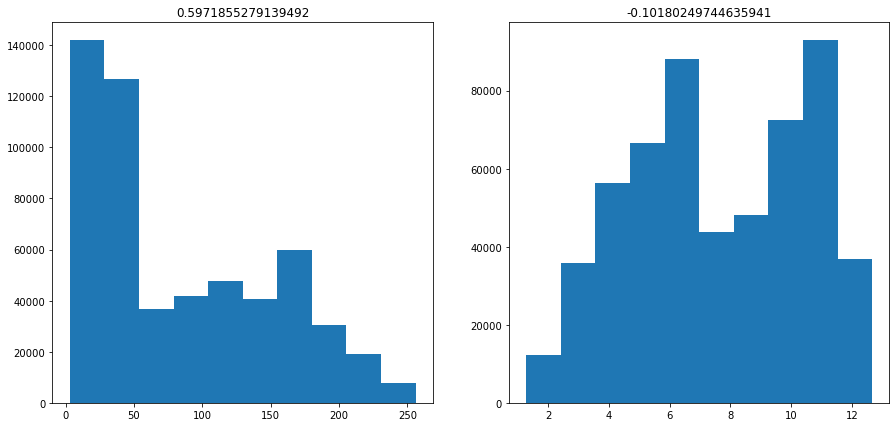

In [36]:
#Analisando a assimetria das distribuições
fig, axes = plt.subplots(ncols=2, figsize = (15, 7))
axes[0].hist(agg.antiguedad)
axes[0].set_title(sts.skew(agg.antiguedad))

axes[1].hist(sts.boxcox(agg.antiguedad)[0])
axes[1].set_title(sts.skew(sts.boxcox(agg.antiguedad)[0]))

Text(0.5, 1.0, '-0.00026020558409130793')

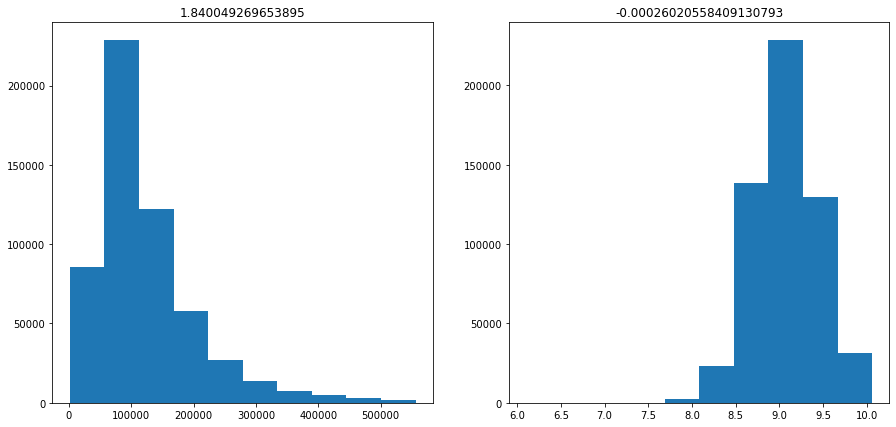

In [37]:
#Analisando a assimetria das distribuições
fig, axes = plt.subplots(ncols=2, figsize = (15, 7))
axes[0].hist(agg.renta)
axes[0].set_title(sts.skew(agg.renta))

axes[1].hist(sts.boxcox(agg.renta)[0])
axes[1].set_title(sts.skew(sts.boxcox(agg.renta)[0]))

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


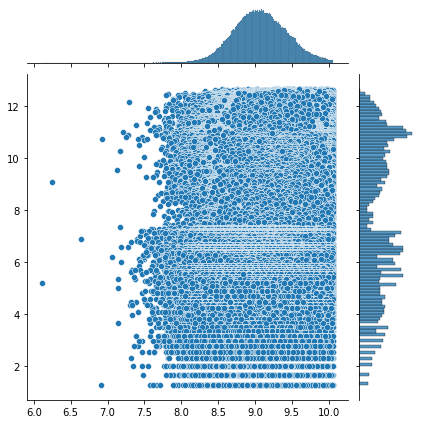

In [38]:
#Analisando a assimetria das distribuições
sns.jointplot(sts.boxcox(agg.renta)[0], sts.boxcox(agg.antiguedad)[0])

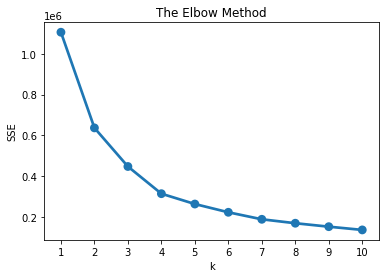

In [39]:
#Padronização por função
def padrao(serie):
    return (serie - serie.mean())/serie.std()


#Criando analise customizada
dados_padronizados = pd.DataFrame({'Renda': padrao(sts.boxcox(agg.renta)[0]), "Senioridade": padrao(sts.boxcox(agg.antiguedad)[0])})

#Testando o Método Elbow
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dados_padronizados)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [40]:
#Observando o Elbow, podemos considerar que 4 clusters são o suficiente
model = KMeans(n_clusters=4, random_state=42)
model.fit(dados_padronizados)
model.labels_.shape


agg["Cluster"] = model.labels_
agg.groupby('Cluster').agg({
    'renta':'mean',
    'antiguedad':'mean',
    'ncodpers': 'count'}).round(2)

,renta,antiguedad,ncodpers
Cluster,,,
0,79587.98,142.44,135656
1,157628.64,30.98,140354
2,209722.30,149.54,124788
3,61365.19,29.76,151754


___
Com base nessa clusterização vamos definir:   
* Cluster 1 com Alto Potencial Junior;
* Cluster 0 com Baixo Potencial Senior;
* Cluster 3 com Baixo Potencial Junior;
* Cluster 2 com Alto Potencial Senior;
___

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


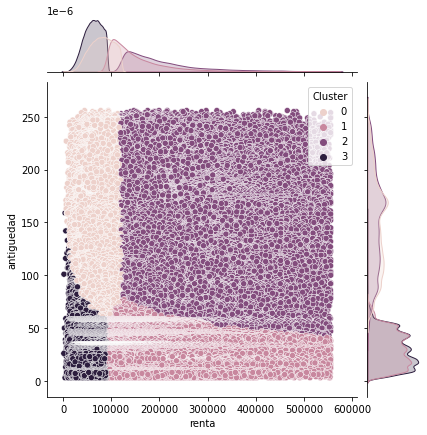

In [41]:
#Analisando a assimetria das distribuições
sns.jointplot(agg.renta, agg.antiguedad, hue=agg.Cluster)

c:\Users\ademir.fazzio\Anaconda3\envs\pht\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='renta', ylabel='Contagem_Prod'>

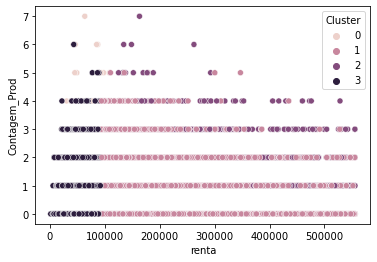

In [42]:
#Analisando como é o uso de produtos de cada cluster com base na renda
sns.scatterplot(agg.renta, agg.Contagem_Prod, hue = agg.Cluster)

___
Agora que fizemos a clusterização com o K-Means e conseguimos identificar alguns clusters e olhando para a renda e a quantidade de Produtos consumidos podemos criar algumas classes com base no potencial:
1. Cluster 0 e 1 com mais do que 2 produtos ou Cluster 2 são Heavy User;
2. Cluster 0 e 1 com menos do que 3 produtos é considerado Medium User;
3. Cluster 3 é considerado totalmente Light User;

___
Agora vamos transpor essa regra e criar uma classificação

In [43]:
#Criando a regra
agg['Type_User'] = 0
agg.loc[((agg.Cluster == 0) | (agg.Cluster == 1) & (agg.Contagem_Prod >= 3)) | (agg.Cluster == 2), 'Type_User']  = 'Heavy User'
agg.loc[((agg.Cluster == 0) | (agg.Cluster == 1)) & (agg.Contagem_Prod < 3), 'Type_User'] = 'Medium User'
agg.loc[(agg.Cluster == 3), 'Type_User'] = 'Light User'

In [44]:
agg['Type_User'].value_counts()

Medium User    275170
Light User     151754
Heavy User     125628
Name: Type_User, dtype: int64

## Agora vamos unir os dados do df_sample e treinar um modelo de classificação com CATBOOST
___

In [45]:
#Cruzando os dados
df_sample_f = pd.merge(df_sample, agg[['ncodpers', 'Type_User']], how = 'left', on='ncodpers')
df_sample_f

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,Contagem_Prod,Type_User
0,2015-01-28,266747,N,ES,V,43,2001-08-09,0.0,167,1.0,...,0,0,0,0,0,0.0,0.0,1,3,Medium User
1,2015-01-28,1068622,N,ES,H,27,2012-09-27,0.0,34,1.0,...,0,0,0,0,0,0.0,0.0,0,1,Medium User
2,2015-01-28,1155287,N,ES,H,25,2013-08-03,0.0,23,1.0,...,0,0,0,0,0,0.0,0.0,0,1,Light User
3,2015-01-28,1252115,N,ES,V,39,2014-04-04,0.0,15,1.0,...,0,0,0,0,0,1.0,1.0,1,3,Light User
4,2015-01-28,922821,N,ES,H,24,2011-07-27,0.0,48,1.0,...,0,0,0,0,0,0.0,0.0,0,1,Light User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090865,2016-05-28,824571,N,ES,V,56,2008-12-30,0.0,24,1.0,...,0,0,0,0,0,1.0,1.0,0,4,Medium User
1090866,2016-05-28,461025,N,ES,V,42,2004-02-24,0.0,147,1.0,...,0,0,0,0,0,0.0,0.0,0,2,Heavy User
1090867,2016-05-28,155803,N,ES,V,65,2000-01-11,0.0,196,1.0,...,0,0,0,0,0,0.0,0.0,0,0,Heavy User
1090868,2016-05-28,1259839,N,ES,V,57,2014-05-26,0.0,24,1.0,...,0,0,0,0,0,0.0,0.0,0,2,Medium User


In [46]:
df_sample_f.dropna(inplace = True)

In [47]:
#Agora que temos nossos dados, vamos simplificar eles pegando apenas o ultimo registro de cada coder
agg = df_sample_f.groupby('ncodpers')['fecha_dato'].max().reset_index()
dados_treino_test = pd.merge(df_sample_f, agg, how = 'inner', on = ['ncodpers', 'fecha_dato'])
dados_treino_test

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,Contagem_Prod,Type_User
0,2015-01-28,818866,N,ES,V,40,2008-11-22,0.0,80,1.0,...,0,0,0,0,0,0.0,0.0,0,4,Medium User
1,2015-02-28,528365,N,ES,H,61,2005-04-13,0.0,123,1.0,...,0,0,0,0,0,0.0,0.0,0,1,Heavy User
2,2015-01-28,938135,N,ES,H,24,2011-09-02,0.0,46,1.0,...,0,0,0,0,0,0.0,0.0,0,1,Light User
3,2015-02-28,550540,N,ES,H,53,2005-08-22,0.0,119,1.0,...,0,0,0,0,0,0.0,0.0,0,1,Medium User
4,2015-02-28,174421,N,ES,H,42,2000-04-28,0.0,183,1.0,...,0,0,0,0,0,0.0,0.0,0,3,Heavy User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552547,2016-05-28,824571,N,ES,V,56,2008-12-30,0.0,24,1.0,...,0,0,0,0,0,1.0,1.0,0,4,Medium User
552548,2016-05-28,461025,N,ES,V,42,2004-02-24,0.0,147,1.0,...,0,0,0,0,0,0.0,0.0,0,2,Heavy User
552549,2016-05-28,155803,N,ES,V,65,2000-01-11,0.0,196,1.0,...,0,0,0,0,0,0.0,0.0,0,0,Heavy User
552550,2016-05-28,1259839,N,ES,V,57,2014-05-26,0.0,24,1.0,...,0,0,0,0,0,0.0,0.0,0,2,Medium User


In [48]:
#Retirando dados duplicados
dados_treino_test = dados_treino_test.loc[~(dados_treino_test.ncodpers.duplicated())]

In [49]:
#Analisando o data set
dados_treino_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548656 entries, 0 to 552550
Data columns (total 48 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   fecha_dato             548656 non-null  datetime64[ns]
 1   ncodpers               548656 non-null  int64         
 2   ind_empleado           548656 non-null  object        
 3   pais_residencia        548656 non-null  object        
 4   sexo                   548656 non-null  object        
 5   age                    548656 non-null  int32         
 6   fecha_alta             548656 non-null  datetime64[ns]
 7   ind_nuevo              548656 non-null  float64       
 8   antiguedad             548656 non-null  int32         
 9   indrel                 548656 non-null  float64       
 10  indrel_1mes            548656 non-null  object        
 11  tiprel_1mes            548656 non-null  object        
 12  indresi                548656 non-null  obje

In [74]:
#Treiando um modelo
from re import X
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

#Agora vamos separar os dados
number_y = dados_treino_test.iloc[:, 47].map({'Heavy User': 1, 'Medium User': 2,  'Light User': 3})
x_train, X_test, y_train, Y_test = train_test_split(dados_treino_test.iloc[:, 20:47].drop(labels=['segmento'], axis = 1), number_y, test_size=0.2)
x_train, X_test, y_train, Y_test

#Treinando o modelo de forma generica
model = CatBoostClassifier(learning_rate = 0.005)
model.fit(x_train, y_train)
y_pred = model.predict(X_test)

0:	learn: 1.0930285	total: 101ms	remaining: 1m 40s
1:	learn: 1.0874855	total: 167ms	remaining: 1m 23s
2:	learn: 1.0820433	total: 233ms	remaining: 1m 17s
3:	learn: 1.0766494	total: 299ms	remaining: 1m 14s
4:	learn: 1.0713148	total: 381ms	remaining: 1m 15s
5:	learn: 1.0660555	total: 454ms	remaining: 1m 15s
6:	learn: 1.0608529	total: 526ms	remaining: 1m 14s
7:	learn: 1.0557227	total: 600ms	remaining: 1m 14s
8:	learn: 1.0506704	total: 680ms	remaining: 1m 14s
9:	learn: 1.0456576	total: 751ms	remaining: 1m 14s
10:	learn: 1.0407113	total: 819ms	remaining: 1m 13s
11:	learn: 1.0358157	total: 896ms	remaining: 1m 13s
12:	learn: 1.0309776	total: 962ms	remaining: 1m 13s
13:	learn: 1.0262049	total: 1.03s	remaining: 1m 12s
14:	learn: 1.0215017	total: 1.11s	remaining: 1m 13s
15:	learn: 1.0168449	total: 1.18s	remaining: 1m 12s
16:	learn: 1.0122357	total: 1.24s	remaining: 1m 11s
17:	learn: 1.0076717	total: 1.32s	remaining: 1m 12s
18:	learn: 1.0031725	total: 1.39s	remaining: 1m 11s
19:	learn: 0.9987471	t

In [75]:
#Avaliando o modelo
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
accuracy_score(Y_test, y_pred)

0.7930138883826049

In [76]:
#Olhando como ficou as classes
dados_treino_test.iloc[:, 47].value_counts()

Medium User    273305
Light User     151055
Heavy User     124296
Name: Type_User, dtype: int64

___
Olhando para apenas a acurácia há uma previsão muito boa, mas vamos olhar classe a classe!   
___

In [77]:
y_pred.reshape(1, -1)[0]

array([2, 1, 3, ..., 3, 1, 2], dtype=int64)

In [78]:
#Criando um Dataset
mapa = {'Heavy User': 1, 'Medium User': 2,  'Light User': 3}

#Vamos olhar lasse a classe e a precisão e o recall dessas classes
print(classification_report(Y_test, y_pred, target_names = mapa.keys(), zero_division=0))

              precision    recall  f1-score   support

  Heavy User       0.77      0.76      0.76     24830
 Medium User       0.84      0.73      0.78     54567
  Light User       0.75      0.94      0.84     30335

    accuracy                           0.79    109732
   macro avg       0.79      0.81      0.79    109732
weighted avg       0.80      0.79      0.79    109732



___
Agora que foram feitas as previsões, é necessario realizar uma análise para explicar o modelo.   
Vamos usar o SHAP que é uma biblioteca com capacidade de analisar a explicabilidade dos modelos de ML.
___

In [79]:
#Importando shap
import shap

#Explicador
explicador = shap.TreeExplainer(model = model)
shap_valores = explicador.shap_values(X_test)

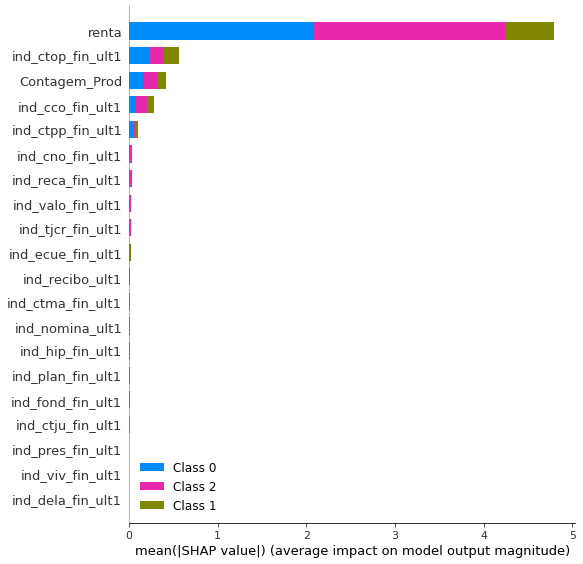

In [80]:
#Sumarizando
shap.summary_plot(shap_valores, features= X_test.columns)

___
Veja que, sumarizando o impacto na aprendizagem de cada um dos campos, a renda se torna o principal indicador de predição.   

Além disso, um campo específico dos produtos também indica uma predição de classe que é o ***ind_ctop_fin_ult1***. Esse campo se mostrou mais importante que a contagem de produtos antes e depois!   
Em suma, esse campo representa o consumo de um produto definido como "Particular Account" e a presença desse produto provavelmente indica qual a classe do cliente.   
Fora esse campo a contagem acaba apresentando um impacto assim como o 4º e o 5º do rank que representa respectivamente "Current Account" e "Particular Plus Account".   


Veja que, fora a renda, todos os produtos que indicam algo sobre o tipo de conta incluem informação útil na predição. Isto é, o tipo de conta e a renda de uma pessoa é um bom preditor se essa pessoa é ou não um **HEAVY USER**.
___

___
Pontos a serem levantados:   
1. Esse case não é completamente real, em cases reais há um certo problema com essa abordagem especialmente devido a falta de estabilidade da clusterização com novos dados não há garantias de reprodutibilidade;
2. Outro ponto importante, esse case é sintético, foram tomadas certas decisões para facilitar a solução proposta, especialmente ao que diz respeito as classes. As classes tiveram números suficientes de registros para um modelo, no entanto, no mundo real pode existir um desbalanceamento exagerado das classes;
3. Vale ressaltar, modelos de clusterização infelizmente tem certa negação por parte dos stakeholders pela falta de explicabilidade desses modelos, pois nesse caso foram utilizadas apenas 2 variáveis e é fácil de observar visualmente. No entanto, em modelos reais, há casos de várias variáveis interagindo entre si deixando complexo demais.
___